In [1]:
%matplotlib inline
import quandl
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as mpl
import random
import numpy as np
from datetime import datetime
import scipy.cluster.hierarchy as sch
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [13]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (12, 8)

In [30]:
df=pd.DataFrame()
df['SP500']=quandl.get("CHRIS/CME_SP1", authtoken=token).Settle
df['Copper']=quandl.get("CHRIS/CME_HG1", authtoken=token).Settle
df['Gold']=quandl.get("CHRIS/CME_GC1", authtoken=token).Settle
df['USD Index']=quandl.get("CHRIS/ICE_DX1", authtoken=token).Settle
df['US 10Y']=quandl.get("CHRIS/CME_US1", authtoken=token).Settle
df['Wheat']=quandl.get("CHRIS/CME_W1", authtoken=token).Settle
df['Corn']=quandl.get("CHRIS/CME_C1", authtoken=token).Settle
df['Eurodollar']=quandl.get("CHRIS/CME_ED1", authtoken=token).Settle
df['Crude WTI']=quandl.get("CHRIS/CME_CL1", authtoken=token).Settle
df['Eurostoxx 50']=quandl.get("CHRIS/EUREX_FESX1", authtoken=token).Settle
df['US Treasury']=quandl.get("CHRIS/CME_TY1", authtoken=token).Settle
df['Russel']=quandl.get("CHRIS/ICE_TF1", authtoken=token).Settle
df['Euro']=quandl.get("CHRIS/CME_EC1", authtoken=token).Settle
df['GBP']=quandl.get("CHRIS/CME_BP1", authtoken=token).Settle

In [62]:
price=df.resample(rule='m',how='last')
pct_rtns = price.pct_change()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


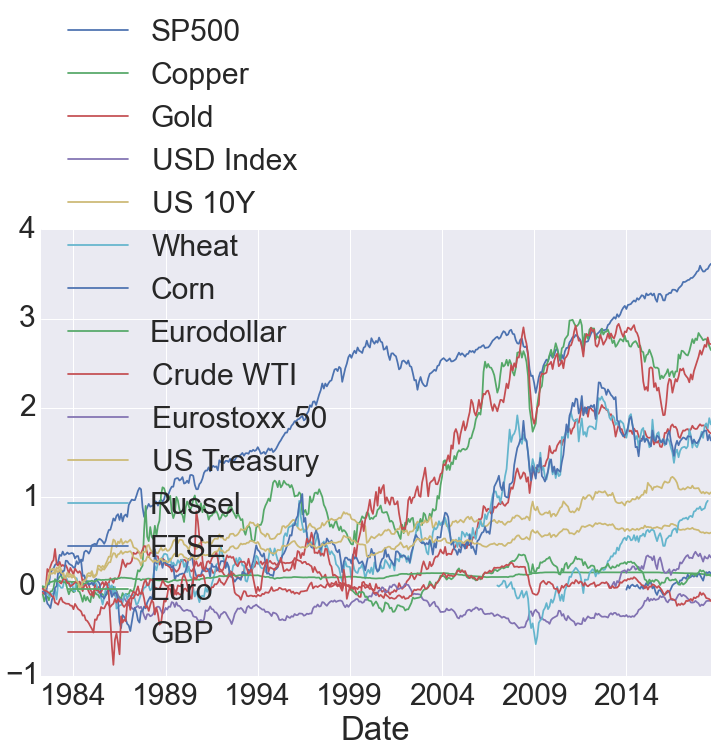

In [63]:
pct_rtns.cumsum().plot()

In [5]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] # number of original items -- this seems wrong to hardwire
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # mfind clusters
        i=df0.index
        j=df0.values-numItems
        sortIx[i]=link[j,0]
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) #item2
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0]) # reindex
    return sortIx.tolist()

In [27]:
def getRecBipart(cov,sortIx):
    # Computer HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initalize all items in one cluster
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        for i in xrange(0,len(cItems),2): # parse in pairs
            cItems0=cItems[i] # cluster 1
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2
    return w

In [7]:
def getIVP(cov,**kargs):
    # Compute the invere-variance portfolio
    ivp=1/np.diag(cov)
    ivp/=ivp.sum()
    return ivp

In [8]:
def getClusterVar(cov,cItems):
    # Computer variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

In [9]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    dist=((1-corr)/2.)**.5
    return dist

In [64]:
cov=pct_rtns.cov()
corr=pct_rtns.corr()

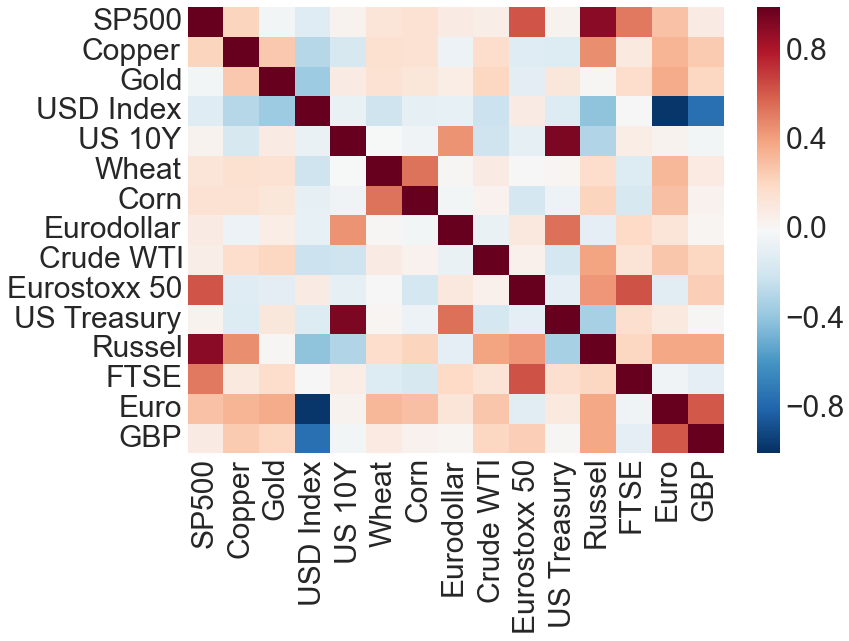

In [65]:
sns.heatmap(corr)

In [66]:
dist=correlDist(corr)
link=sch.linkage(dist,'single')
sortIx=getQuasiDiag(link)
sortIx=corr.index[sortIx].tolist()
df0=corr.loc[sortIx,sortIx]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


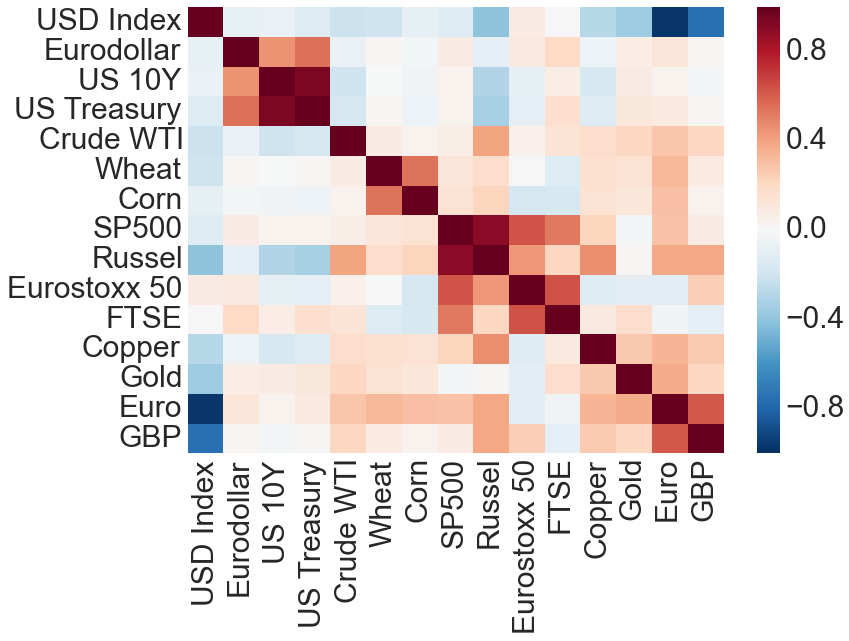

In [67]:
sns.heatmap(df0)

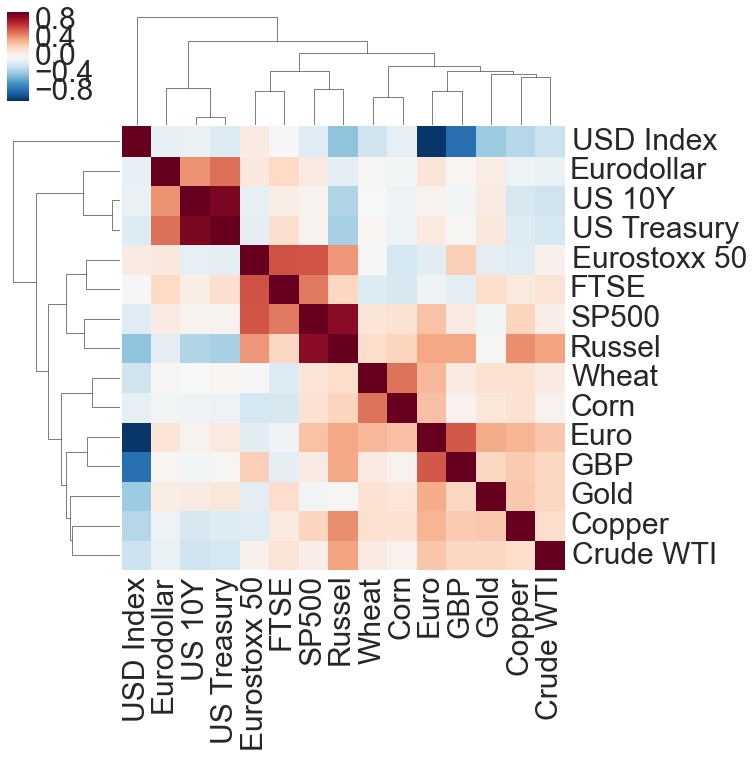

In [70]:
sns.clustermap(corr)

In [71]:
hrp=getRecBipart(cov,sortIx)

In [81]:
final_portfolio = pd.DataFrame()
final_portfolio['HRP']=(hrp*pct_rtns).sum(axis=1)
final_portfolio['1/N']=pct_rtns.mean(axis=1)

In [75]:
def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

In [99]:
final_portfolio['Risk Parity']=(pct_rtns*.05/pct_rtns.std()).mean(axis=1)

In [100]:
final_portfolio.std()*math.sqrt(12)

HRP            0.061792
1/N            0.074160
Risk Parity    0.068067
dtype: float64

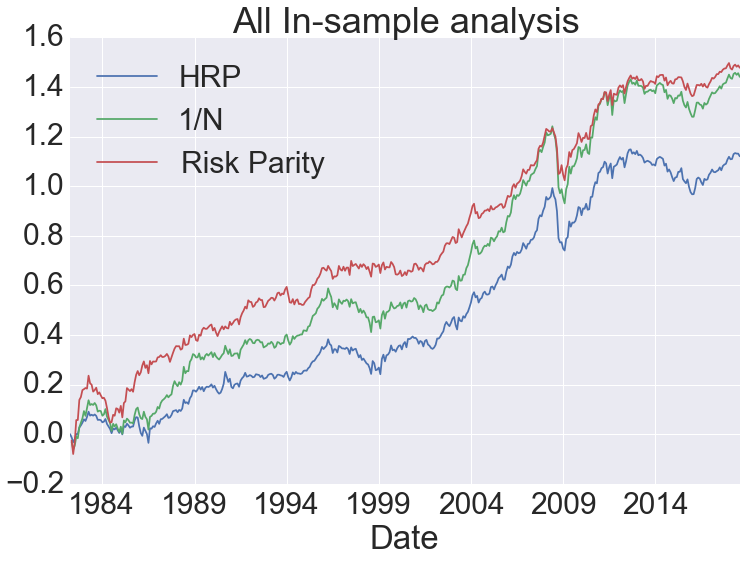

In [104]:
final_portfolio.cumsum().plot(title='All In-sample analysis')